# 03 - Dự báo & can thiệp (Intervention)

Phân loại: Logistic, Decision Tree, Random Forest - dự báo nguy cơ đột quỵ, ROC/AUC.

## 1. Import thư viện & nạp dữ liệu
- Import các thư viện cần thiết
- Đọc dữ liệu từ file CSV
- Tách biến số và biến phân loại, chuẩn bị dữ liệu

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, RocCurveDisplay,
    confusion_matrix, classification_report
)
%matplotlib inline

data_path = '../healthcare-dataset-stroke-data.csv'
df = pd.read_csv(data_path)
target = 'stroke'
X = df.drop(columns=[target])
y = df[target]
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]
print(f'Data shape: {df.shape}, target balance: {y.value_counts().to_dict()}')

Data shape: (5110, 12), target balance: {0: 4861, 1: 249}


## 2. Tiền xử lý dữ liệu & chia tập train/test
- Xử lý missing values, chuẩn hóa biến số, mã hóa biến phân loại
- Chia dữ liệu train/test (stratify theo target)

In [3]:
# Pipeline tiền xử lý
preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ],
    remainder='drop'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (4088, 11), Test: (1022, 11)


## 3. Logistic Regression baseline
- Huấn luyện mô hình Logistic Regression
- Đánh giá: AUC, confusion matrix, classification report, ROC curve

Logistic Regression: AUC=0.841
Confusion matrix:
[[726 246]
 [ 10  40]]

Classification report:
              precision    recall  f1-score   support

           0      0.986     0.747     0.850       972
           1      0.140     0.800     0.238        50

    accuracy                          0.750      1022
   macro avg      0.563     0.773     0.544      1022
weighted avg      0.945     0.750     0.820      1022



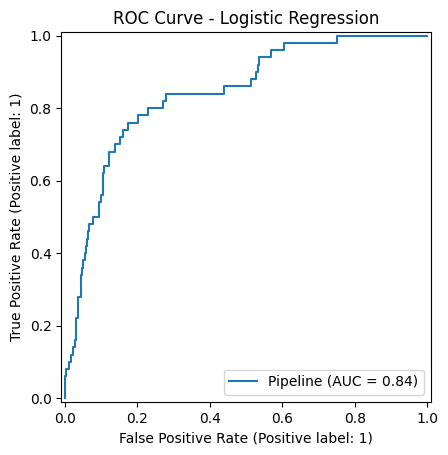

In [4]:
clf_lr = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])
clf_lr.fit(X_train, y_train)
y_proba_lr = clf_lr.predict_proba(X_test)[:, 1]
y_pred_lr = (y_proba_lr >= 0.5).astype(int)
auc_lr = roc_auc_score(y_test, y_proba_lr)
print(f'Logistic Regression: AUC={auc_lr:.3f}')
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred_lr))
print('\nClassification report:')
print(classification_report(y_test, y_pred_lr, digits=3))

RocCurveDisplay.from_estimator(clf_lr, X_test, y_test)
plt.title('ROC Curve - Logistic Regression')
plt.show()

## 4. Hàm đánh giá mô hình phân loại
- Hàm dùng chung cho các mô hình: in accuracy, AUC, confusion matrix, classification report

In [5]:
def eval_clf(name, model):
    pipe = Pipeline([('preprocess', preprocess), ('model', model)])
    pipe.fit(X_train, y_train)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe, 'predict_proba') else None
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    cm = confusion_matrix(y_test, y_pred)
    print(f'\n{name}')
    print(f'Accuracy: {acc:.3f}' + (f', AUC: {auc:.3f}' if auc is not None else ''))
    print('Confusion matrix:')
    print(cm)
    print('Classification report:')
    print(classification_report(y_test, y_pred, digits=3))

## 5. Decision Tree & Random Forest
- Huấn luyện và đánh giá Decision Tree
- Huấn luyện và đánh giá Random Forest

In [6]:
# Decision Tree
print('--- Decision Tree ---')
eval_clf('Decision Tree', DecisionTreeClassifier(
    max_depth=None, min_samples_split=2, class_weight='balanced', random_state=42
))

# Random Forest
print('--- Random Forest ---')
eval_clf('Random Forest', RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_split=2,
    n_jobs=-1, class_weight='balanced_subsample', random_state=42
))

--- Decision Tree ---

Decision Tree
Accuracy: 0.935, AUC: 0.549
Confusion matrix:
[[950  22]
 [ 44   6]]
Classification report:
              precision    recall  f1-score   support

           0      0.956     0.977     0.966       972
           1      0.214     0.120     0.154        50

    accuracy                          0.935      1022
   macro avg      0.585     0.549     0.560      1022
weighted avg      0.919     0.935     0.927      1022

--- Random Forest ---

Decision Tree
Accuracy: 0.935, AUC: 0.549
Confusion matrix:
[[950  22]
 [ 44   6]]
Classification report:
              precision    recall  f1-score   support

           0      0.956     0.977     0.966       972
           1      0.214     0.120     0.154        50

    accuracy                          0.935      1022
   macro avg      0.585     0.549     0.560      1022
weighted avg      0.919     0.935     0.927      1022

--- Random Forest ---

Random Forest
Accuracy: 0.950, AUC: 0.789
Confusion matrix:
[[971

## 6. Tổng kết & Nhận xét mô hình
- So sánh các mô hình: Logistic, Decision Tree, Random Forest
- Đưa ra nhận xét về hiệu quả, ưu nhược điểm, hướng cải tiến